# Capstone Project: Where are you most likely to find a specific kind of venue in Paris ?

## 1. Introduction to the Problem

For this project, I've chosen to study **venues in Paris** and in which **arrondissement** they are most likely to appear. For instance, if you're a italian tourist in Paris, and craving for those italian pastas you miss so much. You might then wonder in which neighborhood you should head to in order to find what you're looking for.  
  
Another application could be that you have the project of opening a museum. You might want to know in which neighborhood you're the most likely to find other museums and match the demand there.

The **target** can be then very wide : from citizens looking for a place to a professional trying to start a business

## 2. The data

I will need two sources of datas for this project
* I will need the list of neighborhoods of Paris, which I can find on the [data.gouv website](https://www.data.gouv.fr/fr/datasets/r/4765fe48-35fd-4536-b029-4727380ce23c)
* I will then need to extract the venues of the different neighborhoods in Paris through the Foursquare API

## 3. Methodology : Classification

I will then do a **Decision Tree** to look for classification in those neighborhoods. 
The data will be split into a training and a testing data set and the best depth maximum will be chosen in order to maximise the accuracy.
The variables explaining the data set will be a one hot encoding of the types of venues and the variable to be explained will be the the neighborhood.  


## 4. Results
I will then be able to predict in which neighborhood you're the most likely to find a specific kind of place. The results are then plotted on a map of Paris : the type of venue and the corresponding neighborhood.

## 5. Discussion
This part will be developped at the end of the notebook

## 6. Conclusion
This part will be developped at the end of the notebook  

In [1]:
!pip install folium

     |████████████████████████████████| 92kB 12.3MB/s eta 0:00:01


In [24]:
import pandas as pd
import numpy as np
import json
import folium
import requests
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

Let's get started

## 2.The data
### Get the list of Paris Neighborhoods

We here download the list of neighborhoods of Paris on the data.gouv website as a json file.

In [3]:
!wget -q -O 'paris_data.json' https://www.data.gouv.fr/fr/datasets/r/4765fe48-35fd-4536-b029-4727380ce23c
print('Data downloaded!')

Data downloaded!


In [4]:
with open('paris_data.json') as json_data:
    paris_data = json.load(json_data)

Extract the "features" part of the json file, which is the part where the data is located

In [5]:
#extract the part where the data is
arr_data = paris_data['features']

We now need to transform this data into a DataFrame

In [6]:
# define the dataframe columns
column_names = ['Arrondissement', 'Latitude', 'Longitude'] 

# instantiate the dataframe
arr = pd.DataFrame(columns=column_names)

for data in arr_data:
    arrondissement = data['properties']['l_aroff']
        
    neighborhood_latlon = data['properties']['geom_x_y']
    latitude = neighborhood_latlon[0]
    longitude = neighborhood_latlon[1]
    
    arr = arr.append({'Arrondissement': arrondissement,
                                          'Latitude': latitude,
                                          'Longitude': longitude}, ignore_index=True)

In [7]:
arr

,Arrondissement,Latitude,Longitude
0,Observatoire,48.829245,2.326542
1,Popincourt,48.859059,2.380058
2,Temple,48.862872,2.360001
3,Louvre,48.862563,2.336443
4,Entrepôt,48.876130,2.360728
5,Vaugirard,48.840085,2.292826
6,Bourse,48.868279,2.342803
7,Hôtel-de-Ville,48.854341,2.357630
8,Batignolles-Monceau,48.887327,2.306777
9,Buttes-Montmartre,48.892569,2.348161


In [8]:
print('There are indeed {} arrondissement in Paris'.format(arr.shape[0]))

There are indeed 20 arrondissement in Paris


### Map of Paris and its neighborhoods

We now plot the map of Paris and its arrondissements to have an overview.
We first get the coordinates of Paris and then add the markers

In [10]:
address = 'Paris'

geolocator = Nominatim(user_agent="paris_explorer")
location = geolocator.geocode(address)
paris_latitude = location.latitude
paris_longitude = location.longitude
print('The geograpical coordinate of Paris are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Paris are 48.8349743815, 2.42132490078.


In [25]:
# create map of Paris using latitude and longitude values
map_paris = folium.Map(location=[paris_latitude, paris_longitude], zoom_start=12)

# add markers to map
for lat, lng, arrondissement in zip(arr['Latitude'], arr['Longitude'], arr['Arrondissement']):
    label = '{}'.format(arrondissement)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris)  
    
map_paris

### Get venues from Foursquare

Now that we have data about the neighborhoods, we investgate the venues that populate them.  
We first enter my credentials and then define a function that exracts the venues for each neighborhoods

In [14]:
CLIENT_ID = 'KHP2ALXRH4ZO0AFY0Y2T2DIA1A5F1U5KYJOBUWSNPAFFCQU0' # your Foursquare ID
CLIENT_SECRET = 'YV35030ASPVOMQ4PLSID0BIPU2AUC1XUB3RMFCFNOKYSUGD1' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: KHP2ALXRH4ZO0AFY0Y2T2DIA1A5F1U5KYJOBUWSNPAFFCQU0
CLIENT_SECRET:YV35030ASPVOMQ4PLSID0BIPU2AUC1XUB3RMFCFNOKYSUGD1


In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
LIMIT=1000
paris_venues = getNearbyVenues(names=arr['Arrondissement'],
                                   latitudes=arr['Latitude'],
                                   longitudes=arr['Longitude'])

Observatoire
Popincourt
Temple
Louvre
Entrepôt
Vaugirard
Bourse
Hôtel-de-Ville
Batignolles-Monceau
Buttes-Montmartre
Élysée
Opéra
Gobelins
Luxembourg
Buttes-Chaumont
Panthéon
Palais-Bourbon
Ménilmontant
Passy
Reuilly


Here is an few of the venues that we got.

In [17]:
print(paris_venues.shape)
paris_venues.head()

(1378, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Observatoire,48.829245,2.326542,La Fabrica,48.827711,2.327819,Pizza Place
1,Observatoire,48.829245,2.326542,Dominique Saibron,48.827965,2.327376,Bakery
2,Observatoire,48.829245,2.326542,Les Jardins Contini,48.829856,2.328848,Italian Restaurant
3,Observatoire,48.829245,2.326542,Marks & Spencer Food,48.828513,2.327862,Food & Drink Shop
4,Observatoire,48.829245,2.326542,Les Pipelettes,48.831805,2.326385,Tea Room


## 3. Methodology : Classification

### Prepare the dataset

Here we will use a onehot encoding on the venue types. This will help for the classification. We then split between X (the variables that explain) and y (the variable to be explained).

In [18]:
onehot = pd.get_dummies(paris_venues[['Venue Category']], prefix="", prefix_sep="")
onehot['Venue'] = paris_venues['Venue']

df = paris_venues.join(onehot.set_index('Venue'), on='Venue')
df.drop(columns=['Venue Category', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Latitude', 'Venue Longitude'], inplace = True)
df.head(2)

,Neighborhood,Venue,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Observatoire,La Fabrica,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Observatoire,Dominique Saibron,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
X = df.drop(columns=['Venue', 'Neighborhood'])
y = df['Neighborhood'].values

In [20]:
#normalize data
from sklearn import preprocessing
X= preprocessing.StandardScaler().fit(X).transform(X)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


In [21]:
# Decision Tree
# We split between training set and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (1260, 203) (1260,)
Test set: (316, 203) (316,)


### Training the Decision Tree

Here we train the algorithm and choose the max depth to use in order to maximise the accuracy

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

MD = 20
acc_DT = np.zeros((MD-1))
for n in range(1,MD):
    
    #Train Model and Predict  
    drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = n)
    drugTree.fit(X_train,y_train)    
    predTree = drugTree.predict(X_test)    
    acc_DT[n-1]=metrics.accuracy_score(y_test, predTree)

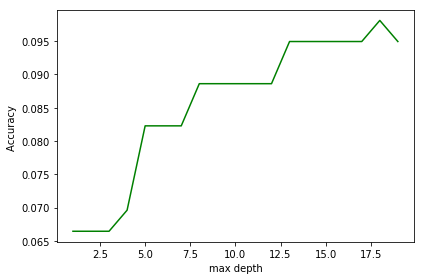

The best accuracy was with 0.0981012658227848 with depth= 18


In [28]:
import matplotlib.pyplot as plt
plt.plot(range(1,MD),acc_DT,'g')
plt.ylabel('Accuracy ')
plt.xlabel('max depth')
plt.tight_layout()
plt.show()
print( "The best accuracy was with", acc_DT.max(), "with depth=", acc_DT.argmax()+1)

In [29]:
drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = acc_DT.argmax()+1)
drugTree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=18,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## 4. Results

Now that the model is trained, we can now choose the type of venues we want to do the prediction on.  
We first create a function that we will use for the prediction

In [30]:
def to_predict(X_names):
    yhat=[]
    
    #create the X set to predict
    X_pred = df.drop(columns=['Venue', 'Neighborhood']).head(len(X_names)).copy()
    X_pred[X_pred.eq(1)]=0
    for i, name in enumerate(X_names):
        X_pred[name][i] = 1
        
    #do the prediction
    yhat = drugTree.predict(X_pred)
    
    return(yhat)

In [31]:
#set which type of venue you want to search
X_name = ['Italian Restaurant', 'Museum']
yhat = to_predict(X_name)
yhat

array(['Temple', 'Temple'], dtype=object)

### Plot the map

here we plot the map of Paris, adding as markers the venues corresponding to the prediction (only first item of the array of prediction) and the neighborhood predicted.

In [32]:
#map_paris = folium.Map(location=[latitude, longitude], zoom_start=12)

# extract a dataframe of venues corresponding to the data predicted
df = paris_venues[paris_venues['Venue Category'] == X_name[0]]

# add markers to map
for lat, lng, venue in zip(df['Venue Latitude'], df['Venue Longitude'], df['Venue']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris)  

#add marker for the neighborhood predicted
pred = paris_venues[paris_venues['Neighborhood'] == yhat[0]].iloc[0]
lat = pred['Neighborhood Latitude']
lng = pred['Neighborhood Longitude']

folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=folium.Popup('IM HERE : {}'.format(yhat[0]), parse_html=True),
        color='red',
        fill=True,
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris)

map_paris

## 5.Discussion

Though we can predecit several results at a time (different request regarding the venues), the map would not be easily readable if we would plot all the results at the same time. To do so we would need fewer data but that would impact the accuracy of our model.

Another point that can be discussed is how relevent is the information for someone trying to open a business : would a neighborhood likely to have museums around would be a good place to open one ? Another study could be perform on the impact on concurrence and monopoly on a business.

## 6. Conclusion

In this project we gathered information about Paris : on its neighborhoods and its venues. The results are satisfying 